# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

In [1]:
import tensorflow as tf

2025-01-20 15:31:16.870620: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-20 15:31:16.882092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737387076.895662  179776 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737387076.898859  179776 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 15:31:16.911304: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
tf.config.get_visible_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

In [4]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x, train_stats):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, history, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.


In [5]:
URI = './ENB2012_data.xlsx'

In [7]:
df = pd.read_excel(URI)

In [8]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [9]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.71,710.5,269.5,220.50,3.5,4,0.40,4,14.47,17.23
1,0.98,514.5,294.0,110.25,7.0,3,0.10,2,24.31,25.63
2,0.74,686.0,245.0,220.50,3.5,2,0.10,2,10.42,13.39
3,0.64,784.0,343.0,220.50,3.5,2,0.40,2,19.20,21.72
4,0.86,588.0,294.0,147.00,7.0,3,0.25,1,30.05,28.61


In [10]:
train, test = train_test_split(df, test_size=0.2)

In [12]:
train_stats = train.describe()
train_stats

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.767313,669.001629,317.821661,175.589984,5.295603,3.530945,0.235668,2.794788,22.515059,24.790749
std,0.105550,87.788020,43.388270,45.061164,1.750832,1.121430,0.133768,1.554944,10.113272,9.528612
min,0.620000,514.500000,245.000000,110.250000,3.500000,2.000000,0.000000,0.000000,6.010000,10.900000
25%,0.690000,588.000000,294.000000,122.500000,3.500000,3.000000,0.100000,1.000000,13.000000,15.785000
50%,0.760000,661.500000,318.500000,147.000000,7.000000,4.000000,0.250000,3.000000,19.600000,24.690000
75%,0.860000,735.000000,343.000000,220.500000,7.000000,5.000000,0.400000,4.000000,31.832500,33.292500
max,0.980000,808.500000,416.500000,220.500000,7.000000,5.000000,0.400000,5.000000,43.100000,47.590000


In [13]:
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()

In [14]:
train_Y = format_output(train)
test_Y = format_output(test)

In [16]:
norm_train_X = norm(train, train_stats)
norm_test_X = norm(test, train_stats)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [22]:
# Define model layers.
input_layer = Input(shape=(len(train.columns),))
first_dense = Dense(units=128, activation='relu')(input_layer)
second_dense = Dense(units=128, activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units=1, name='y1_output')(second_dense)
third_dense = Dense(units=64, activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units=1, name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

I0000 00:00:1737387413.823968  179776 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5566 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │      1,152 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     16,512 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y1_output (Dense)   │ (None, 1)         │        129 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y2_output (Dense)   │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,114 (102.01 KB)

 Trainable params: 26,114 (102.01 KB)

 Non-trainable params: 0 (0.00 B)

None


## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [24]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss={'y1_output': 'mse', 'y2_output': 'mse'},
    metrics={
        'y1_output': tf.keras.metrics.RootMeanSquaredError(),
        'y2_output': tf.keras.metrics.RootMeanSquaredError()
    })

## Train the Model

In [25]:
history = model.fit(norm_train_X, train_Y, epochs=300, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/300


I0000 00:00:1737387582.079476  182128 service.cc:148] XLA service 0x7f603401a260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737387582.079684  182128 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-01-20 15:39:42.101779: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737387582.161184  182128 cuda_dnn.cc:529] Loaded cuDNN version 90300


45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 763.5651 - y1_output_loss: 355.7193 - y1_output_root_mean_squared_error: 18.4482 - y2_output_loss: 407.8459 - y2_output_root_mean_squared_error: 19.7564

I0000 00:00:1737387583.939169  182128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 636.6638 - y1_output_loss: 295.6989 - y1_output_root_mean_squared_error: 16.6240 - y2_output_loss: 340.8841 - y2_output_root_mean_squared_error: 17.8733 - val_loss: 32.1788 - val_y1_output_loss: 14.6706 - val_y1_output_root_mean_squared_error: 3.8692 - val_y2_output_loss: 17.0036 - val_y2_output_root_mean_squared_error: 4.1482
Epoch 2/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 31.8717 - y1_output_loss: 13.4716 - y1_output_root_mean_squared_error: 3.6663 - y2_output_loss: 18.4053 - y2_output_root_mean_squared_error: 4.2679 - val_loss: 60.3376 - val_y1_output_loss: 16.3450 - val_y1_output_root_mean_squared_error: 4.0419 - val_y2_output_loss: 44.3804 - val_y2_output_root_mean_squared_error: 6.6333
Epoch 3/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 28.5893 - y1_output_loss: 11.2655 - y1_output_root_mean_squared_error: 3.3289 - y2_output_loss: 17.3232 - y2_output_root_mean_squared_error: 4.1426 - val_loss: 21.6263 - val_y1_outp

In [26]:
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print(f"Loss = {loss}, Y1_loss = {Y1_loss}, Y1_mse = {Y1_rmse}, Y2_loss = {Y2_loss}, Y2_mse = {Y2_rmse}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - loss: 1.2313 - y1_output_loss: 0.3273 - y1_output_root_mean_squared_error: 0.5693 - y2_output_loss: 0.8971 - y2_output_root_mean_squared_error: 0.9495
Loss = 1.150528907775879, Y1_loss = 0.268673837184906, Y1_mse = 0.5223587155342102, Y2_loss = 0.8612176179885864, Y2_mse = 0.9368405342102051


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


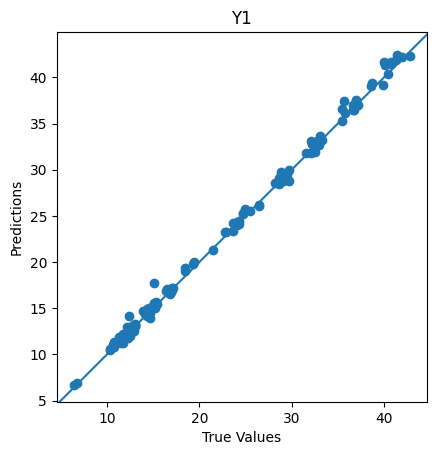

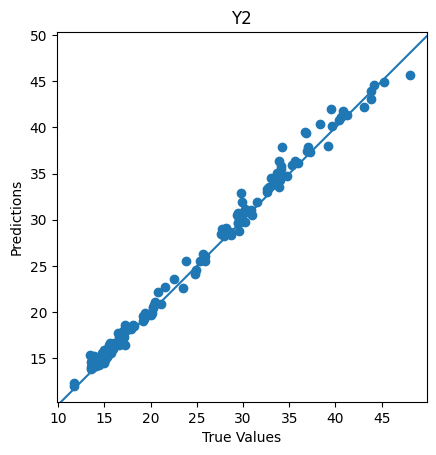

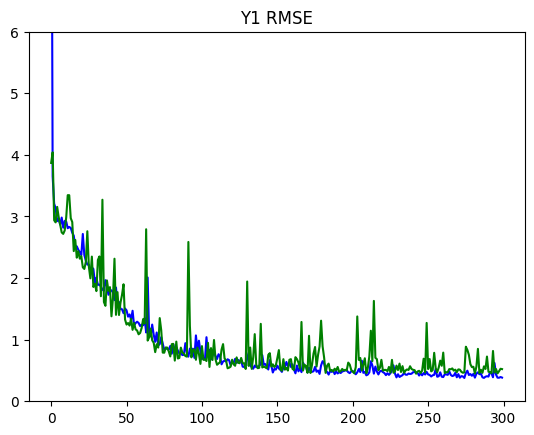

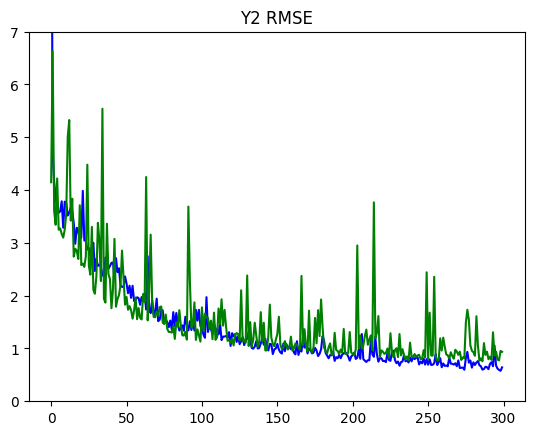

In [28]:
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', history=history, ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', history=history, ylim=7)